# Предсказание ротамеров угла $\chi_1$ в зависимости от окружения

Дедлайн 4 декабря

In [281]:
import json
import pandas as pd
import numpy as np

## Запустите следующую клетку. Будет случайно выбрана аминокислота, для которой вы будете проводить исследование

In [2]:
amacid_names = ['ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'HIS', 'ILE', 'LEU',
                'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

print(f"Моя аминокислота - {np.random.choice(amacid_names)}")

Моя аминокислота - ILE


## Загрузите <a href="https://yadi.sk/d/FeLl5KYfjbhHgA?w=1">отсюда</a> соответствующий файл. Далее мы будем работать с ним.

# Часть 1. Анализ значений угла $\chi_1$

## Задание 1.1. Откроем загруженный файл. Посмотрим на колонки:

In [3]:
!pwd

/Users/mac-julia/Documents/proteins_hse


In [11]:
!ls

HW_3_smollkina_side-chains_task.ipynb obsolete
Lectures                              side-chain data
__pycache__                           side-chain data.zip
docking-potential-design.ipynb        side-chain data.zip.download
geometry.py                           z8
lennard-jones_12-6.csv


In [282]:
#dpath = "/Users/andreyignatov/Downloads/SER_data.csv" 
dpath =  "/Users/mac-julia/Documents/proteins_hse/side-chain data/ILE_data.csv"

In [283]:
df = pd.read_csv(dpath)

In [284]:
df.head()

Unnamed: 0 pbd_indx         phi         psi         tau       alpha  \
0           0     2BO5 -132.673875  143.415464  131.682519  132.908004   
1           1     2BO5  -58.525876  -46.093168   91.839903   39.513266   
2           2     2BO5  -65.144927  -32.202032   89.886732   49.391530   
3           3     2BO5  -67.271147  -49.556771   94.279261   38.174192   
4           4     2BO5  -67.401125  -38.312026   91.813249   57.449097   

   ind_from_start  ind_from_end sec_structure  is_tail  ...     gamma14  \
0              10           109             -        0  ...  149.497815   
1              13           106             H        0  ...   70.701617   
2              44            75             H        0  ...   53.288917   
3              85            34             H        0  ...  143.678835   
4             101            18             H        0  ...   82.929903   

      alpha15      beta15    gamma15    alpha16      beta16     gamma16  \
0   41.249609   45.624462  87.362901  35.804617   97.974890  123.708933   
1   40.707637   52.906550  59.405290  58.525391  125.539369   66.865025   
2   14.692650  113.218466  75.453066  54.015264   62.254251   70.714861   
3  109.953109  103.997430  31.013922  29.953156   90.677448   67.046059   
4   96.622779  105.015224  55.540807  54.778124   56.230851  144.518962   

      alpha17      beta17    gamma17  
0   43.206417  128.453892  80.477189  
1   43.699178   96.296884  52.406747  
2  131.691470   92.295745  47.250501  
3   68.871953   49.519534  64.581228  
4   20.361839   10.698696  85.074644  

[5 rows x 301 columns]

In [285]:
df_copy = df.copy()

Эта таблица содержит информацию о сэмплах одной аминокислоты. Для каждого сэмпла известны:
- Значения всех двугранных углов $\chi$;
- Значения $\phi, \psi, \alpha$ (двугранный угол, построенный по 4 последовательным атомам $C_\alpha$);
- Данные о 17 ближайших пространственных соседях:
    - $\phi, \psi$;
    - Названия аминокислот;
    - Расстояние до целевой аминокислоты по $C_\alpha$;
    - Химические / физикохимические характеристики соседа: группы и точные значения некоторых характеристик;
    - Дополнительные геометрические характеристики (относительно целевой аминокислоты).

## Задание 1.2. Постройте гистограмму значений $\chi_1$ из этой таблицы. Какие ротамеры выделяются на этой гистограмме?

In [7]:
import matplotlib.pyplot as plt

In [286]:
df = df[~np.isnan(df["chi_1"])]

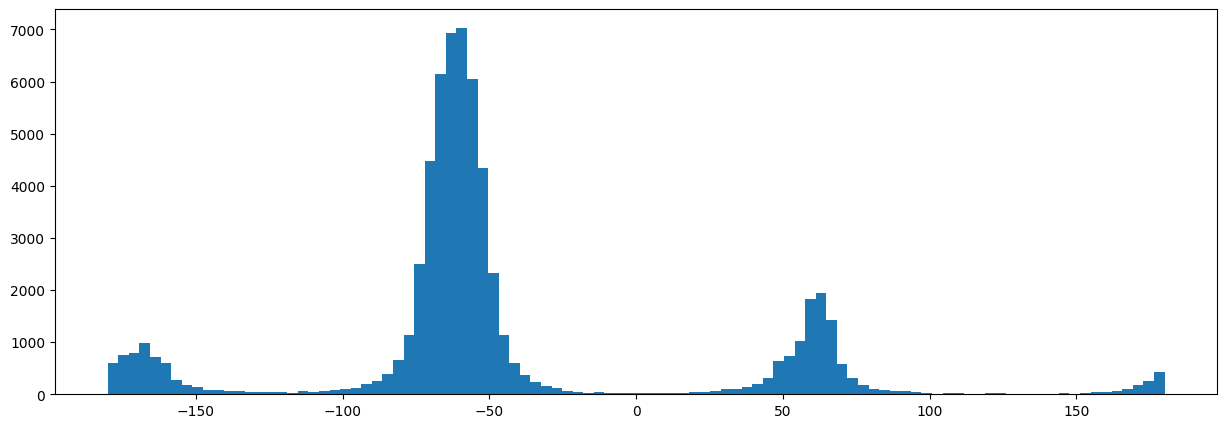

In [17]:
plt.figure(figsize=(15,5))
plt.hist(df["chi_1"], bins=100)
plt.show()

Занесите обнаруженные ротамеры в список rotamers:

In [6]:
rotamers = np.array([60, -60, 170])

## Задание 1.3. Давайте разберемся, как можно дискретизировать значения (разделить их на классы). Реализуйте функцию get_class(value, rotamers), которая возвращает индекс ротамера, к которому относится значение value.

**Комментарий**: стоит вычислять расстояние от value до каждого значения из rotamers. Но не забудьте, что с точки зрения окружности $-\pi$ и $\pi$ - одно и то же!

In [7]:
def get_class(value, rotamers):
    diffs = np.abs(value - rotamers)
    diffs = np.minimum(diffs, 360 - diffs)
    return np.argmin(diffs)

In [12]:
plt.figure(figsize=(15,5))
classes = [get_class(val, rotamers) for val in df["chi_1"]]

for i in np.unique(classes):
    plt.hist(df["chi_1"].values[classes == i], bins=200, range=(-180, 180))

plt.xticks(np.arange(-180, 180, 20))
plt.show()

NameError: name 'plt' is not defined

## Задание 1.4. Теперь мы умеем делить значения $\chi_1$ на классы, т.е. можем понять, к какому ротамеру относится то или иное значение.
Реализуем первую часть подхода Dunbrack. Шаги:
- Разделить карту Рамачандрана на блоки $20 x 20$. Для каждого блока нужно найти те сэмплы из выборки, которые входят в него.
- Для всех найденных сэмплов нужно получить индексы классов; после этого выбрать класс, встречающийся чаще всего, и сохранить его в соответствующую ячейку матрицы **most_common_rotamers**.
    - Если получилось меньше 10 значений для некоторого блока, нужно получить наиболее частый класс для всей выборки.

In [8]:
all_rots = [get_class(val, rotamers) for val in df["chi_1"]]
all_un_rots, all_un_cnts = np.unique(all_rots, return_counts=True)

most_common = all_un_rots[np.argmax(all_un_cnts)]

In [9]:
most_common

1

In [10]:
most_common_rotamers = np.full((18, 18), np.nan)
for phi_ind in range(18):
    phi_st = -180 + 20 * phi_ind
    phi_end = -180 + 20 * (phi_ind + 1)
    for psi_ind in range(18):
        psi_st = -180 + 20 * psi_ind
        psi_end = -180 + 20 * (psi_ind + 1)
        
        loc_data = df[(df["phi"] >= phi_st) & (df["phi"] < phi_end) & 
                      (df["psi"] >= psi_st) & (df["psi"] < psi_end)]
        if loc_data.shape[0] < 10:
            most_common_rotamers[psi_ind, phi_ind] = most_common
        else:
            loc_rots = [get_class(val, rotamers) 
                        for val in loc_data["chi_1"]]
            loc_un_rots, loc_un_cnts = np.unique(loc_rots, 
                                                 return_counts=True)
            most_common_rotamers[psi_ind, phi_ind] = loc_un_rots[np.argmax(loc_un_cnts)]
            

Отобразите получившуюся матрицу с помощью plt.imshow: 

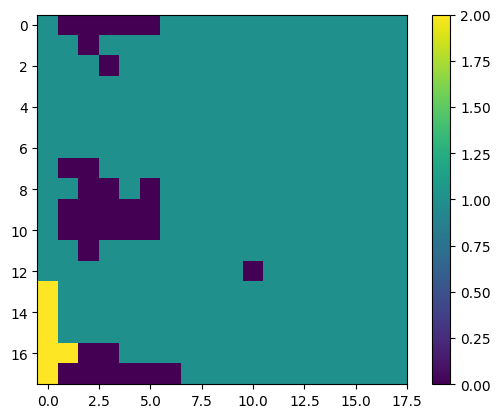

In [24]:
plt.imshow(most_common_rotamers)

plt.colorbar()
plt.show()

Какие выводы можно сделать на основании изображения выше? Можно ли сказать, что какой-то ротамер характерен для определенной вторичной структуры?

# $\rightarrow$ Ваши идеи 🙂

## Задание 1.5. А насколько вообще состоятелен подход к поиску пересечений, основанный на энергии van der Waals?

Давайте возьмем достаточно длинный белок $1Z87$, откроем его и изучим:

In [2]:
!pip install Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.8/272.8 kB 507.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.1 MB/s eta 0:00:00a 0:00:01


In [11]:
import Bio.PDB as pdb

In [12]:
path = pdb.PDBList().retrieve_pdb_file("1z87", 
                                       file_format="pdb")
struct = pdb.PDBParser().get_structure("s", path)

Structure exists: '/Users/mac-julia/Documents/proteins_hse/z8/pdb1z87.ent' 


Получите 0-ую цепочку этого белка, найдите в ней индексы всех цистеинов (CYS):

In [13]:
chain = struct[0].child_list[0]
residues = chain.child_list
cys_inds = [i for i in range(len(chain)) 
            if residues[i].resname == "CYS"]

cys_inds

[15, 218, 231]

Выберите первый найденный цистеин. Будем менять для него угол $\chi_1$ и смотреть, как будет меняться энергия ван дер Ваальса при взаимодействии с другими атомами.

$U_{LJ} = 4 \cdot \epsilon \cdot [(\frac{r_{min}}{r})^{12} - 2 \cdot (\frac{r_{min}}{r})^6]$

In [14]:
lj_coeffs = pd.read_csv("lennard-jones_12-6.csv", delimiter="\t")
lj_coeffs.head()

atom_pair  reqm    eps
0       C-C     4   0,15
1       C-N  3,75  0,155
2       C-O   3,6  0,173
3       C-S     4  0,173
4       C-H     3  0,055

In [15]:
def van_der_Waals(d, d_m, eps):
    return  4 * eps * (((d_m / d) ** 12) - 2 * ((d_m / d) ** 6))

Изменяя двугранный угол в пределах $[-\pi, \pi)$:
- Вычислите новые координаты атома SG у цистеина. Для этого можно воспользоваться функциями из файла geometry.py (из первого ДЗ).
- После получения координат, их можно присвоить с помощью метода:

    residue["CG"].set_coord(new_cg1_coord)
- После этого вычислите суммарную энергию ван дер Ваальса взаимодействия со всеми другими атомами белка.

In [16]:
from geometry import *

Для удобства сделаем словарь из таблицы с коэффициентами потенциала типа Леннарда-Джонса:

In [17]:
lj_coeffs = {row[0]: {"d_min": float(row[1].replace(",", ".")), 
                      "eps": float(row[2].replace(",", "."))} for row in lj_coeffs.values}
lj_coeffs

{'C-C': {'d_min': 4.0, 'eps': 0.15},
 'C-N': {'d_min': 3.75, 'eps': 0.155},
 'C-O': {'d_min': 3.6, 'eps': 0.173},
 'C-S': {'d_min': 4.0, 'eps': 0.173},
 'C-H': {'d_min': 3.0, 'eps': 0.055},
 'N-C': {'d_min': 3.75, 'eps': 0.155},
 'N-N': {'d_min': 3.5, 'eps': 0.16},
 'N-O': {'d_min': 3.35, 'eps': 0.179},
 'N-S': {'d_min': 3.75, 'eps': 0.179},
 'N-H': {'d_min': 2.75, 'eps': 0.057},
 'O-C': {'d_min': 3.6, 'eps': 0.173},
 'O-N': {'d_min': 3.35, 'eps': 0.179},
 'O-O': {'d_min': 3.2, 'eps': 0.2},
 'O-S': {'d_min': 3.6, 'eps': 0.2},
 'O-H': {'d_min': 2.6, 'eps': 0.063},
 'S-C': {'d_min': 4.0, 'eps': 0.173},
 'S-N': {'d_min': 3.75, 'eps': 0.179},
 'S-O': {'d_min': 3.6, 'eps': 0.2},
 'S-S': {'d_min': 4.0, 'eps': 0.2},
 'S-H': {'d_min': 3.0, 'eps': 0.063},
 'H-C': {'d_min': 3.0, 'eps': 0.055},
 'H-N': {'d_min': 2.75, 'eps': 0.057},
 'H-O': {'d_min': 2.6, 'eps': 0.063},
 'H-S': {'d_min': 3.0, 'eps': 0.063},
 'H-H': {'d_min': 2.0, 'eps': 0.02}}

In [18]:
def calc_vdw_w_residue(ref_residue, residue):
    ref_atoms = [at 
                 for at in ref_residue.child_list 
                 if at not in ["C", "N", "CA", "CB", "O"] and at.element[0] != "H"]
    atoms = [at 
             for at in residue.child_list 
             if at.element[0] != "H"]
    
    ds, d_ms, epses = [], [], []
    for at1 in ref_atoms:
        for at2 in atoms:
            pair = "{}-{}".format(at1.element, at2.element)
            ds += [at1 - at2]
            d_ms += [lj_coeffs[pair]["d_min"]]
            epses += [lj_coeffs[pair]["eps"]]
            
    ds =    np.array(ds)
    d_ms =  np.array(d_ms)
    epses = np.array(epses)
    
    return van_der_Waals(ds, d_ms, epses).sum()
    

In [19]:
calc_vdw_w_residue(chain[2], chain[3])

157461.58689638547

In [20]:
chi1_vals = np.arange(-np.pi, np.pi, np.pi/10)

cys_residue = residues[cys_inds[0]]

chi1_true = pdb.calc_dihedral(cys_residue["N"].get_vector(),
                              cys_residue["CA"].get_vector(),
                              cys_residue["CB"].get_vector(),
                              cys_residue["SG"].get_vector(),                             
                             )
planar = pdb.calc_angle(cys_residue["CA"].get_vector(),
                      cys_residue["CB"].get_vector(),
                      cys_residue["SG"].get_vector())
bond = cys_residue["SG"] - cys_residue["CB"]
prev_atoms = np.array([cys_residue["N"].coord, 
                       cys_residue["CA"].coord, 
                       cys_residue["CB"].coord, 
                      ])

vdw_vals = []

for chi1 in chi1_vals:
    new_coord = place_next_dihedral_atom(prev_atoms, chi1, planar, bond)
    cys_residue["SG"].set_coord(new_coord)
    
    vdw_sum = 0
    for k in range(len(residues)):
        if k == cys_inds[0]:
            continue
        
        vdw_sum += calc_vdw_w_residue(cys_residue, residues[k])
    
    vdw_vals += [vdw_sum]

In [21]:
vdw_vals

[316494.9523184497,
 316494.5906475921,
 316494.05579365446,
 316493.3601221159,
 316492.64517937024,
 316492.16385490814,
 316492.78472152667,
 316494.6289854579,
 316498.8750134774,
 316528.64588691585,
 316674.7817079582,
 316866.37963295047,
 316733.978590917,
 316602.96995294496,
 316560.22929702845,
 316511.48357548914,
 316493.0136240393,
 316491.72926440986,
 316493.6624564071,
 316494.86535087216]

In [22]:
chi1_vals

array([-3.14159265, -2.82743339, -2.51327412, -2.19911486, -1.88495559,
       -1.57079633, -1.25663706, -0.9424778 , -0.62831853, -0.31415927,
        0.        ,  0.31415927,  0.62831853,  0.9424778 ,  1.25663706,
        1.57079633,  1.88495559,  2.19911486,  2.51327412,  2.82743339])

Постройте график для получившихся значений энергии. Какой вывод можно сделать из него?

In [23]:
chi1_true/np.pi*180

-154.84349620456356

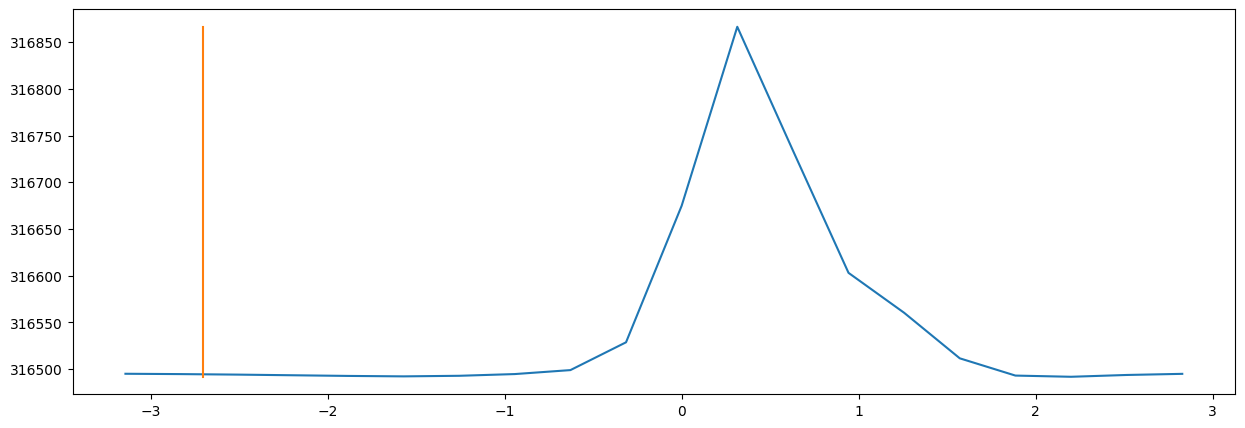

In [44]:
plt.figure(figsize=(15,5))
plt.plot(chi1_vals, vdw_vals)
plt.plot([chi1_true, chi1_true], [min(vdw_vals), max(vdw_vals)])
plt.show()

Вполнне состоятельно оценивать пересечение групп атомов при большом значении Ван-дервальса

# Часть 2. Предсказание ротамеров $\chi_1$

В этой части Вам предстоит применить методы Машинного Обучения (деревья решений) к задаче предсказания ротамеров Вашей аминокислоты.

## Задание 2.1. Вернемся к датасету из части 1. Добавьте колонку chi_class, которая получается преобразованием значений из колонки chi_1 к классам.

In [58]:
# изменение угла (x+ pi)//(2*pi/18)

In [287]:
from math import pi

In [288]:
t = []
for i in df["chi_1"]:
    t.append((i+pi)//(2*pi/18))

In [289]:
t

[-488.0,
 -476.0,
 -158.0,
 -308.0,
 -144.0,
 -156.0,
 162.0,
 -198.0,
 -135.0,
 -164.0,
 185.0,
 -125.0,
 -259.0,
 151.0,
 91.0,
 -170.0,
 -501.0,
 -132.0,
 65.0,
 90.0,
 -195.0,
 -180.0,
 -429.0,
 210.0,
 -142.0,
 -161.0,
 -148.0,
 -180.0,
 -151.0,
 -181.0,
 -133.0,
 -172.0,
 -171.0,
 -204.0,
 -156.0,
 -494.0,
 -477.0,
 -189.0,
 -175.0,
 -469.0,
 -149.0,
 -181.0,
 -155.0,
 -191.0,
 -175.0,
 -179.0,
 -185.0,
 -198.0,
 -190.0,
 -154.0,
 -127.0,
 -215.0,
 -207.0,
 -193.0,
 -196.0,
 205.0,
 -126.0,
 -164.0,
 -452.0,
 253.0,
 515.0,
 -167.0,
 -158.0,
 -160.0,
 173.0,
 -492.0,
 -170.0,
 -179.0,
 -158.0,
 -201.0,
 -180.0,
 -458.0,
 -150.0,
 -165.0,
 -133.0,
 -357.0,
 -206.0,
 -148.0,
 -184.0,
 -145.0,
 -145.0,
 -484.0,
 -172.0,
 -176.0,
 204.0,
 -165.0,
 -127.0,
 -186.0,
 191.0,
 -152.0,
 -133.0,
 -151.0,
 517.0,
 -140.0,
 -177.0,
 189.0,
 213.0,
 -181.0,
 -173.0,
 -211.0,
 -452.0,
 -221.0,
 -183.0,
 -468.0,
 -213.0,
 227.0,
 224.0,
 185.0,
 -190.0,
 -495.0,
 -446.0,
 -158.0,
 -244.0,
 267.

In [290]:
df['chi_class'] = t

## Задание 2.2. Теперь давайте дискретизируем значения $\phi, \psi, \alpha$. Каждому значению из $[-\pi, \pi]$ нужно поставить в соответствие номер блока длиной 20 градусов, в который он попадает.

**Комментарий**: обратите внимание, значения могут быть отрицательными. А номер блока нет 🤔

In [291]:
# всего 18 классов

In [292]:
block = []
for i in t:
    if i%20 == 0:
        block.append(abs(i//20))
    else:
        block.append(abs(i//20+i%20))
block

[13.0,
 20.0,
 6.0,
 4.0,
 8.0,
 4.0,
 10.0,
 8.0,
 2.0,
 7.0,
 14.0,
 8.0,
 12.0,
 18.0,
 15.0,
 1.0,
 7.0,
 1.0,
 8.0,
 14.0,
 5.0,
 9.0,
 11.0,
 20.0,
 10.0,
 10.0,
 4.0,
 9.0,
 1.0,
 9.0,
 0.0,
 1.0,
 0.0,
 5.0,
 4.0,
 19.0,
 21.0,
 1.0,
 4.0,
 13.0,
 3.0,
 9.0,
 3.0,
 1.0,
 4.0,
 8.0,
 5.0,
 8.0,
 0.0,
 2.0,
 6.0,
 6.0,
 2.0,
 3.0,
 6.0,
 15.0,
 7.0,
 7.0,
 15.0,
 25.0,
 40.0,
 4.0,
 6.0,
 8.0,
 21.0,
 17.0,
 1.0,
 8.0,
 6.0,
 8.0,
 9.0,
 21.0,
 2.0,
 6.0,
 0.0,
 15.0,
 3.0,
 4.0,
 6.0,
 7.0,
 7.0,
 9.0,
 1.0,
 5.0,
 14.0,
 6.0,
 6.0,
 4.0,
 20.0,
 0.0,
 0.0,
 1.0,
 42.0,
 7.0,
 6.0,
 18.0,
 23.0,
 9.0,
 2.0,
 2.0,
 15.0,
 7.0,
 7.0,
 12.0,
 4.0,
 18.0,
 15.0,
 14.0,
 0.0,
 20.0,
 9.0,
 6.0,
 3.0,
 20.0,
 25.0,
 0.0,
 4.0,
 3.0,
 4.0,
 2.0,
 2.0,
 8.0,
 9.0,
 1.0,
 2.0,
 5.0,
 2.0,
 6.0,
 25.0,
 5.0,
 3.0,
 8.0,
 8.0,
 0.0,
 5.0,
 10.0,
 8.0,
 4.0,
 21.0,
 4.0,
 16.0,
 2.0,
 11.0,
 8.0,
 15.0,
 1.0,
 0.0,
 7.0,
 2.0,
 1.0,
 4.0,
 1.0,
 12.0,
 14.0,
 6.0,
 25.0,
 4.0,
 5.0,
 3.0,
 

In [293]:
df['block'] = block

## Задание 2.3. В датасете есть текстовые признаки! Так как они категориальные, их значения можно поменять на натуральные числа. Пронумеруйте все уникальные значения таких признаков и измените текстовые значения на соответствующие номера. 

In [294]:
df = df.drop(['Unnamed: 0'], axis=1)
df

pbd_indx         phi         psi         tau       alpha  \
0         2BO5 -132.673875  143.415464  131.682519  132.908004   
1         2BO5  -58.525876  -46.093168   91.839903   39.513266   
2         2BO5  -65.144927  -32.202032   89.886732   49.391530   
3         2BO5  -67.271147  -49.556771   94.279261   38.174192   
4         2BO5  -67.401125  -38.312026   91.813249   57.449097   
...        ...         ...         ...         ...         ...   
63041     5X1X -121.353153  126.716381  124.146485 -144.929397   
63042     5X1X -100.731831  101.492657  110.033866  143.276514   
63043     5X1X  -73.092971  -30.659857   91.436514   42.510484   
63044     5X1X  -46.594126  -55.146881   91.555714   40.063601   
63045     5X1X  -51.648374  -45.613184   90.002077   61.432708   

       ind_from_start  ind_from_end sec_structure  is_tail       chi_1  ...  \
0                  10           109             -        0 -173.454724  ...   
1                  13           106             H        0 -169.000874  ...   
2                  44            75             H        0  -57.954325  ...   
3                  85            34             H        0 -110.633803  ...   
4                 101            18             H        0  -53.128974  ...   
...               ...           ...           ...      ...         ...  ...   
63041              78            51             E        0  -85.049371  ...   
63042             101            28             -        0  -71.525675  ...   
63043             106            23             T        0  -56.233248  ...   
63044             119            10             H        0  -89.346228  ...   
63045             125             4             H        0  -58.705122  ...   

           beta15     gamma15     alpha16      beta16     gamma16     alpha17  \
0       45.624462   87.362901   35.804617   97.974890  123.708933   43.206417   
1       52.906550   59.405290   58.525391  125.539369   66.865025   43.699178   
2      113.218466   75.453066   54.015264   62.254251   70.714861  131.691470   
3      103.997430   31.013922   29.953156   90.677448   67.046059   68.871953   
4      105.015224   55.540807   54.778124   56.230851  144.518962   20.361839   
...           ...         ...         ...         ...         ...         ...   
63041  142.713770   98.575763  128.941322   45.503916   56.835975   68.407924   
63042  132.837890   66.013573   42.864891   97.835056  127.403928   42.556767   
63043  125.127891   83.346626   71.770644  172.688151   93.315752   86.056729   
63044  105.615707  116.902444   59.775282   18.430398   82.098894   54.403891   
63045  116.630002   40.703348   55.307949  151.915169   63.827735   56.689129   

           beta17     gamma17  chi_class  block  
0      128.453892   80.477189     -488.0   13.0  
1       96.296884   52.406747     -476.0   20.0  
2       92.295745   47.250501     -158.0    6.0  
3       49.519534   64.581228     -308.0    4.0  
4       10.698696   85.074644     -144.0    8.0  
...           ...         ...        ...    ...  
63041  172.074909   94.987919     -235.0    7.0  
63042   80.423456  132.556159     -196.0    6.0  
63043   30.563075  100.715354     -153.0    1.0  
63044   50.741328   40.997152     -247.0    0.0  
63045  168.923460   99.853882     -160.0    8.0  

[62825 rows x 302 columns]

In [295]:
df_copy = df.copy()

In [296]:
df.head()

pbd_indx         phi         psi         tau       alpha  ind_from_start  \
0     2BO5 -132.673875  143.415464  131.682519  132.908004              10   
1     2BO5  -58.525876  -46.093168   91.839903   39.513266              13   
2     2BO5  -65.144927  -32.202032   89.886732   49.391530              44   
3     2BO5  -67.271147  -49.556771   94.279261   38.174192              85   
4     2BO5  -67.401125  -38.312026   91.813249   57.449097             101   

   ind_from_end sec_structure  is_tail       chi_1  ...      beta15  \
0           109             -        0 -173.454724  ...   45.624462   
1           106             H        0 -169.000874  ...   52.906550   
2            75             H        0  -57.954325  ...  113.218466   
3            34             H        0 -110.633803  ...  103.997430   
4            18             H        0  -53.128974  ...  105.015224   

     gamma15    alpha16      beta16     gamma16     alpha17      beta17  \
0  87.362901  35.804617   97.974890  123.708933   43.206417  128.453892   
1  59.405290  58.525391  125.539369   66.865025   43.699178   96.296884   
2  75.453066  54.015264   62.254251   70.714861  131.691470   92.295745   
3  31.013922  29.953156   90.677448   67.046059   68.871953   49.519534   
4  55.540807  54.778124   56.230851  144.518962   20.361839   10.698696   

     gamma17  chi_class  block  
0  80.477189     -488.0   13.0  
1  52.406747     -476.0   20.0  
2  47.250501     -158.0    6.0  
3  64.581228     -308.0    4.0  
4  85.074644     -144.0    8.0  

[5 rows x 302 columns]

In [58]:
# find np.unique

In [ ]:
# найдем колонки с нечисленными значениями

In [297]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
not_num_col = list(set(df.columns.tolist()) - set(num_col))
not_num_col = sorted(not_num_col)
not_num_col

['n_10_charge_group',
 'n_10_chemical_group',
 'n_10_hydrogen_donor_acceptor_group',
 'n_10_hydropathy_group',
 'n_10_physicochemical_group',
 'n_10_polarity_group',
 'n_10_volume_group',
 'n_11_charge_group',
 'n_11_chemical_group',
 'n_11_hydrogen_donor_acceptor_group',
 'n_11_hydropathy_group',
 'n_11_physicochemical_group',
 'n_11_polarity_group',
 'n_11_volume_group',
 'n_12_charge_group',
 'n_12_chemical_group',
 'n_12_hydrogen_donor_acceptor_group',
 'n_12_hydropathy_group',
 'n_12_physicochemical_group',
 'n_12_polarity_group',
 'n_12_volume_group',
 'n_13_charge_group',
 'n_13_chemical_group',
 'n_13_hydrogen_donor_acceptor_group',
 'n_13_hydropathy_group',
 'n_13_physicochemical_group',
 'n_13_polarity_group',
 'n_13_volume_group',
 'n_14_charge_group',
 'n_14_chemical_group',
 'n_14_hydrogen_donor_acceptor_group',
 'n_14_hydropathy_group',
 'n_14_physicochemical_group',
 'n_14_polarity_group',
 'n_14_volume_group',
 'n_15_charge_group',
 'n_15_chemical_group',
 'n_15_hydroge

In [298]:
len(not_num_col)

138

In [299]:
df.applymap(lambda x: isinstance(x, (int, float))) # we need false

pbd_indx   phi   psi   tau  alpha  ind_from_start  ind_from_end  \
0         False  True  True  True   True            True          True   
1         False  True  True  True   True            True          True   
2         False  True  True  True   True            True          True   
3         False  True  True  True   True            True          True   
4         False  True  True  True   True            True          True   
...         ...   ...   ...   ...    ...             ...           ...   
63041     False  True  True  True   True            True          True   
63042     False  True  True  True   True            True          True   
63043     False  True  True  True   True            True          True   
63044     False  True  True  True   True            True          True   
63045     False  True  True  True   True            True          True   

       sec_structure  is_tail  chi_1  ...  beta15  gamma15  alpha16  beta16  \
0              False     True   True  ...    True     True     True    True   
1              False     True   True  ...    True     True     True    True   
2              False     True   True  ...    True     True     True    True   
3              False     True   True  ...    True     True     True    True   
4              False     True   True  ...    True     True     True    True   
...              ...      ...    ...  ...     ...      ...      ...     ...   
63041          False     True   True  ...    True     True     True    True   
63042          False     True   True  ...    True     True     True    True   
63043          False     True   True  ...    True     True     True    True   
63044          False     True   True  ...    True     True     True    True   
63045          False     True   True  ...    True     True     True    True   

       gamma16  alpha17  beta17  gamma17  chi_class  block  
0         True     True    True     True       True   True  
1         True     True    True     True       True   True  
2         True     True    True     True       True   True  
3         True     True    True     True       True   True  
4         True     True    True     True       True   True  
...        ...      ...     ...      ...        ...    ...  
63041     True     True    True     True       True   True  
63042     True     True    True     True       True   True  
63043     True     True    True     True       True   True  
63044     True     True    True     True       True   True  
63045     True     True    True     True       True   True  

[62825 rows x 302 columns]

In [300]:
from random import seed
from random import random
seed(1)

In [301]:
#chose unique values from dataframe not int of float type
cur = set()
for i in not_num_col:
    cur_ = set(df[i])
    cur = cur.union(cur_)  

In [302]:
len(cur)

6109

In [303]:
dict_uniq = {}
for i in cur:
    dict_uniq[i] = len(dict_uniq)
dict_uniq

{nan: 0,
 '2FEK': 1,
 '1VG2': 2,
 '1BHS': 3,
 '2ESQ': 4,
 '6B2V': 5,
 '1EZK': 6,
 '2ADZ': 7,
 '1G03': 8,
 '4LEU': 9,
 '2KHO': 10,
 '1DUA': 11,
 '1LZA': 12,
 '2RRD': 13,
 '2WGN': 14,
 '1TQ3': 15,
 '1XIX': 16,
 '2GBS': 17,
 '1OQA': 18,
 '1K3V': 19,
 '2F0F': 20,
 '1N3Y': 21,
 '3M66': 22,
 '1EY6': 23,
 '4R6F': 24,
 '2ILX': 25,
 '2N4B': 26,
 '5KV1': 27,
 '1U9A': 28,
 '2KZ6': 29,
 '5NR5': 30,
 '2LPX': 31,
 '1UC6': 32,
 '2YT1': 33,
 '6F6O': 34,
 '1BWH': 35,
 '2LKH': 36,
 '2YZ0': 37,
 '1ZYL': 38,
 '3SH4': 39,
 '3WO9': 40,
 '1DKJ': 41,
 '1CBY': 42,
 '1HZK': 43,
 '1WIC': 44,
 '2EYO': 45,
 '3DFG': 46,
 '1RD6': 47,
 '1G84': 48,
 '1GPR': 49,
 '1UB9': 50,
 '2KGR': 51,
 '2NT3': 52,
 '3HNU': 53,
 '4LDM': 54,
 '2DQX': 55,
 '2BAA': 56,
 '2CPC': 57,
 '2LT3': 58,
 '3RPB': 59,
 '2OY8': 60,
 '5P8D': 61,
 '4ZOT': 62,
 '2P03': 63,
 '2QMV': 64,
 '2E5N': 65,
 '2E6J': 66,
 '2DNM': 67,
 '5P7V': 68,
 '5T43': 69,
 '2BID': 70,
 '2RQ1': 71,
 '2YRZ': 72,
 '2K0S': 73,
 '2INY': 74,
 '1N6V': 75,
 '2GT8': 76,
 '4M7G': 77,

In [304]:
df.head()

pbd_indx         phi         psi         tau       alpha  ind_from_start  \
0     2BO5 -132.673875  143.415464  131.682519  132.908004              10   
1     2BO5  -58.525876  -46.093168   91.839903   39.513266              13   
2     2BO5  -65.144927  -32.202032   89.886732   49.391530              44   
3     2BO5  -67.271147  -49.556771   94.279261   38.174192              85   
4     2BO5  -67.401125  -38.312026   91.813249   57.449097             101   

   ind_from_end sec_structure  is_tail       chi_1  ...      beta15  \
0           109             -        0 -173.454724  ...   45.624462   
1           106             H        0 -169.000874  ...   52.906550   
2            75             H        0  -57.954325  ...  113.218466   
3            34             H        0 -110.633803  ...  103.997430   
4            18             H        0  -53.128974  ...  105.015224   

     gamma15    alpha16      beta16     gamma16     alpha17      beta17  \
0  87.362901  35.804617   97.974890  123.708933   43.206417  128.453892   
1  59.405290  58.525391  125.539369   66.865025   43.699178   96.296884   
2  75.453066  54.015264   62.254251   70.714861  131.691470   92.295745   
3  31.013922  29.953156   90.677448   67.046059   68.871953   49.519534   
4  55.540807  54.778124   56.230851  144.518962   20.361839   10.698696   

     gamma17  chi_class  block  
0  80.477189     -488.0   13.0  
1  52.406747     -476.0   20.0  
2  47.250501     -158.0    6.0  
3  64.581228     -308.0    4.0  
4  85.074644     -144.0    8.0  

[5 rows x 302 columns]

In [ ]:
%%time
for i in not_num_col:
    df.replace(dict_uniq)

In [ ]:
df.head()

In [258]:
k = []
for j in not_num_col:
    k = list(k)
    h_dict = {}
    for i in pd.unique(df[j]):
        k.append(i)
    k = set(k)
    for kk in k:
        h_dict[kk] =  len(dict_unique)+random()
    #print(h_dict)
    dict_unique[j] = h_dict #{k:len(dict_unique)+random()}

In [259]:
dict_unique

{'n_10_charge_group': {'-CHARGED': 0.026341071169743935,
  'UNCHARGED': 0.7754823362458928,
  '+CHARGED': 0.703415789402871},
 'n_10_chemical_group': {nan: 138.19351258793571,
  '2ADZ': 138.40489152488848,
  '2KHO': 138.33343512981193,
  '1DUA': 138.0913713598464,
  '2RRD': 138.83180553820264,
  '2WGN': 138.14932095500512,
  '1TQ3': 138.3789751564646,
  '2GBS': 138.78600585868864,
  '1OQA': 138.05321409428637,
  '1K3V': 138.02359087403144,
  '1EY6': 138.78713073635797,
  '2N4B': 138.38015108101058,
  '1U9A': 138.5250735510834,
  '5NR5': 138.836319770124,
  '2LPX': 138.31161238154112,
  '1UC6': 138.55860035569629,
  '2YT1': 138.76310971675522,
  '2LKH': 138.9381437150184,
  '3WO9': 138.7246210756675,
  '1HZK': 138.746417302438,
  '2EYO': 138.65020050442857,
  '3DFG': 138.75293886872137,
  '1G84': 138.8592193319094,
  '1GPR': 138.57262771940546,
  '1UB9': 138.8010792368007,
  '2BAA': 138.08526040520132,
  '2CPC': 138.5243035678607,
  '3RPB': 138.5767477478378,
  '4ZOT': 138.8541138442095

In [147]:
df_not_num = df.loc[:, not_num_col]
df_not_num.drop_duplicates()

n_10_charge_group n_10_chemical_group  \
0              -CHARGED              ACIDIC   
1             UNCHARGED            HYDROXYL   
2             UNCHARGED           ALIPHATIC   
3             UNCHARGED            HYDROXYL   
4             UNCHARGED           ALIPHATIC   
...                 ...                 ...   
63041          +CHARGED               BASIC   
63042         UNCHARGED           ALIPHATIC   
63043         UNCHARGED           ALIPHATIC   
63044         UNCHARGED               AMIDE   
63045         UNCHARGED           ALIPHATIC   

      n_10_hydrogen_donor_acceptor_group n_10_hydropathy_group  \
0                               ACCEPTOR           HYDROPHILIC   
1                         DONOR-ACCEPTOR               NEUTRAL   
2                                   NONE           HYDROPHOBIC   
3                         DONOR-ACCEPTOR               NEUTRAL   
4                                   NONE           HYDROPHOBIC   
...                                  ...                   ...   
63041                              DONOR           HYDROPHILIC   
63042                               NONE           HYDROPHOBIC   
63043                               NONE           HYDROPHOBIC   
63044                     DONOR-ACCEPTOR           HYDROPHILIC   
63045                               NONE           HYDROPHOBIC   

      n_10_physicochemical_group n_10_polarity_group n_10_volume_group  \
0                         ACIDIC               POLAR            MEDIUM   
1                       HYDROXYL               POLAR             SMALL   
2                      ALIPHATIC            NONPOLAR             LARGE   
3                       HYDROXYL               POLAR             SMALL   
4                      ALIPHATIC            NONPOLAR        VERY_SMALL   
...                          ...                 ...               ...   
63041                      BASIC               POLAR             LARGE   
63042                  ALIPHATIC            NONPOLAR        VERY_SMALL   
63043                  ALIPHATIC            NONPOLAR             LARGE   
63044                      AMIDE               POLAR             SMALL   
63045                  ALIPHATIC            NONPOLAR            MEDIUM   

      n_11_charge_group n_11_chemical_group  \
0             UNCHARGED           ALIPHATIC   
1             UNCHARGED           ALIPHATIC   
2             UNCHARGED           ALIPHATIC   
3             UNCHARGED            AROMATIC   
4             UNCHARGED            HYDROXYL   
...                 ...                 ...   
63041          -CHARGED              ACIDIC   
63042         UNCHARGED           ALIPHATIC   
63043         UNCHARGED           ALIPHATIC   
63044          -CHARGED              ACIDIC   
63045          +CHARGED               BASIC   

      n_11_hydrogen_donor_acceptor_group  ... n_name_2 n_name_3 n_name_4  \
0                                   NONE  ...      GLN      ALA      ALA   
1                                   NONE  ...      GLU      ARG      GLY   
2                                   NONE  ...      GLN      VAL      GLU   
3                                   NONE  ...      ASN      ASN      LEU   
4                         DONOR-ACCEPTOR  ...      SER      PHE      PRO   
...                                  ...  ...      ...      ...      ...   
63041                           ACCEPTOR  ...      VAL      GLU      TYR   
63042                               NONE  ...      GLU      GLU      TRP   
63043                               NONE  ...      ASN      GLU      LEU   
63044                           ACCEPTOR  ...      PRO      PRO      ALA   
63045                              DONOR  ...      LYS      THR      ASN   

      n_name_5 n_name_6 n_name_7 n_name_8 n_name_9 pbd_indx sec_structure  
0          VAL      GLY      GLY      SER      VAL     2BO5             -  
1          TYR      TYR      VAL      ILE      ALA     2BO5             H  
2          GLY      LYS      MET      ARG      ALA   

In [149]:
# df = pd.DataFrame(technologies)
# dict_duration = {"30days" : '30', "50days" : '50', "55days": '55',np.nan:'50'}
# df.replace({"Duration": dict_duration},inplace=True)
# print(df)

In [170]:
import time

In [239]:
dict_unique['n_10_charge_group']

{'-CHARGED': 0.026341071169743935,
 'UNCHARGED': 0.7754823362458928,
 '+CHARGED': 0.703415789402871}

In [244]:
%%time
for i in not_num_col:
    print(i, dict_unique[i])
    df.replace({i: dict_unique[i]})

n_name_13 {'CYS': 138.35972175494393, 'ALA': 138.96848139664834, 'TRP': 138.76947784964617, 'MET': 138.00795407208062, 'TYR': 138.5164777916938, 'VAL': 138.82682066678095, 'SER': 138.42131207970922, 'GLU': 138.16305054136615, 'ASN': 138.81458496413617, 'PHE': 138.94827083577576, 'PRO': 138.75630688051484, 'ILE': 138.7828862706051, 'GLN': 138.13027562039647, 'HIS': 138.61112744247475, 'LYS': 138.16099696178105, 'ARG': 138.3772562613329, 'LEU': 138.06576492010322, 'THR': 138.3265377269209, 'ASP': 138.53099430315658, 'GLY': 138.09353664414618}
n_17_volume_group {'CYS': 138.30354952972854, 'ALA': 138.4237674119977, 'TRP': 138.39327240139397, 'MET': 138.0017342473085, 'TYR': 138.68245942473098, 'VERY_SMALL': 138.5107181824153, 'VAL': 138.2073393068692, 'SER': 138.78967133514396, 'GLU': 138.44157141514728, 'ASN': 138.891383029844, 'PHE': 138.347267340463, 'PRO': 138.09544404155284, 'ILE': 138.75032938618267, 'GLN': 138.66797302669528, 'MEDIUM': 138.73653649001713, 'LARGE': 138.17229413418065

n_13_polarity_group {'CYS': 138.85907946016138, 'ALA': 138.77984167200495, 'TRP': 138.962140824342, 'DONOR-ACCEPTOR': 138.27275657862552, 'MET': 138.80379410695102, 'TYR': 138.9932524348174, 'AROMATIC': 138.9770711884853, 'VERY_SMALL': 138.26677076550627, 'POLAR': 138.07054773490108, 'ALIPHATIC': 138.9196849361686, 'P': 138.38511202665808, 'VAL': 138.62674225050128, 'F': 138.0810788672896, 'SER': 138.86599331533446, 'HYDROXYL': 138.86304618474438, 'GLU': 138.39512227687266, 'ASN': 138.74951879515626, '-CHARGED': 138.60603246909724, 'NONPOLAR': 138.6260462502177, 'PHE': 138.90937732021052, 'PRO': 138.0734959375582, 'ILE': 138.0193315769782, 'GLN': 138.62661111480057, 'G': 138.00566472419973, 'BASIC': 138.29479491959341, 'ACIDIC': 138.83846390797856, 'MEDIUM': 138.38156401693107, 'NONE': 138.90122686947973, 'LARGE': 138.74743141336933, 'HIS': 138.61638557028843, '+CHARGED': 138.21216799233935, 'DONOR': 138.18801408414092, 'VERY_LARGE': 138.58810362093402, 'LYS': 138.10340211095019, 'ARG'

n_12_charge_group {'CYS': 138.65767546362832, 'ALA': 138.87776131339567, 'TRP': 138.50504919562852, 'DONOR-ACCEPTOR': 138.30162932165595, 'MET': 138.6212272302232, 'TYR': 138.56943787183977, 'AROMATIC': 138.94403904683367, 'VERY_SMALL': 138.70910054250606, 'POLAR': 138.2890021579195, 'ALIPHATIC': 138.66234671404604, 'P': 138.32280250910918, 'VAL': 138.47878971557643, 'F': 138.22927519741938, 'SER': 138.19027413616993, 'HYDROXYL': 138.1165422801006, 'GLU': 138.2213486681234, 'ASN': 138.75898674949937, '-CHARGED': 138.74519764362537, 'NONPOLAR': 138.7844651745286, 'PHE': 138.93467870832325, 'PRO': 138.98762701021073, 'ILE': 138.8290289993455, 'GLN': 138.90244064995247, 'G': 138.85649636316745, 'BASIC': 138.62288947740996, 'ACIDIC': 138.99289553466517, 'MEDIUM': 138.58400701471183, 'NONE': 138.8057617102524, 'LARGE': 138.82383900237332, 'HIS': 138.96115844870366, '+CHARGED': 138.64663565687843, 'DONOR': 138.29398817436154, 'VERY_LARGE': 138.35000355658815, 'LYS': 138.1088295221749, 'ARG':

n_16_chemical_group {'CYS': 138.3887726148352, 'ALA': 138.02546025439005, 'TRP': 138.90108844982583, 'DONOR-ACCEPTOR': 138.22596169983842, 'MET': 138.22937653317868, 'TYR': 138.933609065711, 'AROMATIC': 138.31851612550096, 'VERY_SMALL': 138.51526967354135, 'POLAR': 138.9579970079628, 'ALIPHATIC': 138.17465587929323, 'P': 138.92055787312984, 'VAL': 138.3342230474706, 'F': 138.75879783295656, 'SER': 138.3852401489197, 'HYDROXYL': 138.94182357735102, 'GLU': 138.81879149310103, 'ASN': 138.73318587775418, '-CHARGED': 138.5834570655744, 'NONPOLAR': 138.41650240726148, 'PHE': 138.17596874783644, 'PRO': 138.78438029836292, 'ILE': 138.28310769733235, 'GLN': 138.81238687398314, 'G': 138.42475957080788, 'BASIC': 138.30369256764604, 'ACIDIC': 138.8757542635519, 'MEDIUM': 138.9227944234914, 'NONE': 138.1067809394672, 'LARGE': 138.96742170797552, 'HIS': 138.3361329890067, '+CHARGED': 138.96378971356066, 'DONOR': 138.85031575704085, 'VERY_LARGE': 138.51857018017174, 'LYS': 138.24460961666819, 'ARG': 

n_14_hydropathy_group {'CYS': 138.67947486130515, 'ALA': 138.9284520289138, 'TRP': 138.63334876102914, 'DONOR-ACCEPTOR': 138.17641016678866, 'MET': 138.01064107163324, 'TYR': 138.8321068740446, 'AROMATIC': 138.10810738763368, 'VERY_SMALL': 138.31173653945538, 'POLAR': 138.1660835059427, 'ALIPHATIC': 138.74457527611344, 'P': 138.34142605146826, 'VAL': 138.4414986455055, 'F': 138.554489400702, 'SER': 138.36822318276626, 'HYDROXYL': 138.79650823036914, 'GLU': 138.09065566279216, 'ASN': 138.44541280366255, '-CHARGED': 138.74029254316451, 'NONPOLAR': 138.68942846837777, 'PHE': 138.82039001401498, 'PRO': 138.21305152087285, 'ILE': 138.67317708986099, 'GLN': 138.20653563224008, 'G': 138.30425789478673, 'BASIC': 138.88620560290522, 'ACIDIC': 138.28431527630144, 'MEDIUM': 138.35961929817188, 'HYDROPHOBIC': 138.86685755283608, 'NONE': 138.2119839451363, 'LARGE': 138.04844150913272, 'HIS': 138.464487378676, '+CHARGED': 138.7065949466845, 'DONOR': 138.7959025473071, 'VERY_LARGE': 138.6672759713193

n_name_2 {'CYS': 138.93469722206163, 'ALA': 138.7170403811729, 'TRP': 138.47776571458954, 'DONOR-ACCEPTOR': 138.671791894557, 'MET': 138.31045304260445, 'TYR': 138.98150485395448, 'AROMATIC': 138.303132641667, 'VERY_SMALL': 138.4708316729614, 'POLAR': 138.76749742286157, 'ALIPHATIC': 138.43090390058035, 'P': 138.20492569183526, 'VAL': 138.06820169791965, 'F': 138.3706797496561, 'SER': 138.82739063127505, 'HYDROXYL': 138.68062559296698, 'GLU': 138.98366462159237, 'ASN': 138.4949882673327, '-CHARGED': 138.8940498476945, 'NONPOLAR': 138.96557976443387, 'PHE': 138.39191598724608, 'PRO': 138.8772605793981, 'ILE': 138.27098299461514, 'GLN': 138.6487193632689, 'G': 138.58211531027717, 'BASIC': 138.60997844064266, 'ACIDIC': 138.89446041881257, 'MEDIUM': 138.12800652709032, 'HYDROPHOBIC': 138.72966035195867, 'NONE': 138.73947121961075, 'LARGE': 138.4855233529164, 'HIS': 138.1497083995598, '+CHARGED': 138.3515041729964, 'DONOR': 138.15140571781666, 'VERY_LARGE': 138.5973349144432, 'LYS': 138.821

n_1_physicochemical_group {'CYS': 138.8687213892157, 'ALA': 138.90979022481653, 'TRP': 138.5769270693409, 'DONOR-ACCEPTOR': 138.01822552813252, 'MET': 138.56841189867342, 'TYR': 138.3600763301783, 'AROMATIC': 138.63834309004784, 'VERY_SMALL': 138.0587537162219, 'POLAR': 138.45289281441336, 'ALIPHATIC': 138.6521479532839, 'P': 138.66022693093106, 'VAL': 138.04995074672945, 'F': 138.1278972258303, 'SER': 138.43245947183777, 'HYDROXYL': 138.9127277246163, 'GLU': 138.47007906650305, 'ASN': 138.46339245505874, '-CHARGED': 138.94472129422354, 'NONPOLAR': 138.52860920974246, 'PHE': 138.16131351903405, 'PRO': 138.50520235058437, 'ILE': 138.85866669900702, 'GLN': 138.76631116704988, 'G': 138.23386041241903, 'BASIC': 138.04078914392468, 'ACIDIC': 138.94115183123338, 'MEDIUM': 138.6392384603575, 'HYDROPHOBIC': 138.67798946886398, 'NONE': 138.12473847113196, 'LARGE': 138.08558696766355, 'HIS': 138.51028903955, '+CHARGED': 138.5838719093113, 'DONOR': 138.60636309940588, 'VERY_LARGE': 138.4189042741

n_6_hydropathy_group {'CYS': 138.1411567566545, 'ALA': 138.97599029744626, 'TRP': 138.1119610897284, 'DONOR-ACCEPTOR': 138.0185398397627, 'MET': 138.19034287604435, 'TYR': 138.4074818767727, 'AROMATIC': 138.5092482847593, 'VERY_SMALL': 138.66315009144793, 'POLAR': 138.7107429650876, 'ALIPHATIC': 138.27181944726658, 'P': 138.47188536372727, 'VAL': 138.52498969150184, 'F': 138.12863804100064, 'SER': 138.94293787054556, 'HYDROXYL': 138.96995281977732, 'GLU': 138.56806307528797, 'ASN': 138.23024419991532, '-CHARGED': 138.71078852501094, 'NONPOLAR': 138.8743264666628, 'PHE': 138.6349403851426, 'PRO': 138.93478406039205, 'ILE': 138.06408559460667, 'GLN': 138.6923011235218, 'G': 138.18198340940597, 'BASIC': 138.6438611852515, 'ACIDIC': 138.03692721383888, 'MEDIUM': 138.4861599444536, 'HYDROPHOBIC': 138.2958171379513, 'NONE': 138.70923321168993, 'LARGE': 138.39234596941287, 'HIS': 138.78289168755543, '+CHARGED': 138.2735091398293, 'DONOR': 138.15270606580467, 'VERY_LARGE': 138.66290666629294, 

n_14_hydrogen_donor_acceptor_group {'CYS': 138.82706467435835, 'ALA': 138.4354094149182, 'TRP': 138.7779633228683, 'DONOR-ACCEPTOR': 138.76629545370926, 'MET': 138.95737756228098, 'TYR': 138.6980192133406, 'AROMATIC': 138.98198314142826, 'VERY_SMALL': 138.71406814602292, 'POLAR': 138.66262732696165, 'ALIPHATIC': 138.50078151249312, 'P': 138.80640540102067, 'VAL': 138.4111952634056, 'F': 138.13869411520108, 'SER': 138.1734553256686, 'HYDROXYL': 138.53120681030853, 'GLU': 138.83805162598435, 'ASN': 138.63820051494656, '-CHARGED': 138.65877033740338, 'NONPOLAR': 138.32081511037663, 'PHE': 138.9227555689116, 'PRO': 138.2415362653506, 'ILE': 138.37301662975167, 'GLN': 138.03880812560004, 'G': 138.96504215782812, 'BASIC': 138.40423219681625, 'ACIDIC': 138.24207296945565, 'MEDIUM': 138.16062162052594, 'HYDROPHOBIC': 138.39534796133333, 'NONE': 138.13783649659447, 'LARGE': 138.08305457141878, 'HIS': 138.60351279863468, '+CHARGED': 138.95761629622245, 'DONOR': 138.6675161126733, 'VERY_LARGE': 1

n_5_hydropathy_group {'2ADZ': 138.91451335530766, '2KHO': 138.67372497613502, '1DUA': 138.06720320939434, '2RRD': 138.0728656769358, '2WGN': 138.1851784270606, '1TQ3': 138.9127104162184, '2GBS': 138.57627536086625, '1OQA': 138.9612220342418, '1K3V': 138.64288952350762, '1EY6': 138.9182484032924, '2N4B': 138.85564520288955, '1U9A': 138.45421721030016, '5NR5': 138.54900276739914, '2LPX': 138.75648254456797, '1UC6': 138.23842255379753, '2YT1': 138.3853857367865, '2LKH': 138.22989688771128, '3WO9': 138.2056044752197, '1HZK': 138.85259008237585, '2EYO': 138.23127285681554, '3DFG': 138.57484087543858, '1G84': 138.54534596361867, '1GPR': 138.7057179659075, '1UB9': 138.33755760412365, '2BAA': 138.44587463344976, '2CPC': 138.71820232459908, '3RPB': 138.06420231065078, '4ZOT': 138.37069357985345, '2P03': 138.70768729995828, '2E6J': 138.82141651641487, '2DNM': 138.740380695465, '5P7V': 138.52573653724198, '5T43': 138.19835929793086, '2BID': 138.4056993789193, '2INY': 138.32122066094144, '2GT8': 1

n_13_physicochemical_group {'2ADZ': 138.42590403985503, '2KHO': 138.90182796241785, '1DUA': 138.95557865294748, '2RRD': 138.23462879105534, '2WGN': 138.04562144549823, '1TQ3': 138.5545615078588, '2GBS': 138.07726354101584, '1OQA': 138.7173848496731, '1K3V': 138.15708500110625, '1EY6': 138.24025592557888, '2N4B': 138.2567881914942, '1U9A': 138.02930488373704, '5NR5': 138.38052716273336, '2LPX': 138.78895963273666, '1UC6': 138.72360998640846, '2YT1': 138.72702814490873, '2LKH': 138.00307516460757, '3WO9': 138.44485603570243, '1HZK': 138.557490193126, '2EYO': 138.69626080208621, '3DFG': 138.84728440740355, '1G84': 138.6865157219848, '1GPR': 138.4603553158523, '1UB9': 138.4320201461129, '2BAA': 138.09086491456839, '2CPC': 138.9694625284078, '3RPB': 138.87327502807494, '4ZOT': 138.42224512140993, '2P03': 138.37161684585962, '2E6J': 138.72899825880864, '2DNM': 138.50715326544957, '5P7V': 138.52434354524163, '5T43': 138.9961831948368, '2BID': 138.7034842025675, '2INY': 138.1554581180976, '2GT

n_13_chemical_group {'2ADZ': 138.90188911265722, '2KHO': 138.59039656931836, '1DUA': 138.3100349664378, '2RRD': 138.37400109711152, '2WGN': 138.72801328839842, '1TQ3': 138.32657616391808, '2GBS': 138.1088837503448, '1OQA': 138.780127862635, '1K3V': 138.00440476137055, '1EY6': 138.92022760689187, '2N4B': 138.9006157696615, '1U9A': 138.60975699417966, '5NR5': 138.25210836206904, '2LPX': 138.08617192682388, '1UC6': 138.7888160783135, '2YT1': 138.4960195497879, '2LKH': 138.25217974345117, '3WO9': 138.03373134597234, '1HZK': 138.81141742137677, '2EYO': 138.82007041889722, '3DFG': 138.93133712171237, '1G84': 138.91966467603274, '1GPR': 138.48003627253016, '1UB9': 138.42433465530993, '2BAA': 138.12855925548817, '2CPC': 138.49595192790306, '3RPB': 138.81279956723998, '4ZOT': 138.76412403615902, '2P03': 138.02583097404488, '2E6J': 138.89230646894822, '2DNM': 138.16612968113643, '5P7V': 138.30388266657621, '5T43': 138.9639980265708, '2BID': 138.26431772267347, '2INY': 138.6957780440106, '2GT8': 

n_14_polarity_group {'2ADZ': 138.9155337372637, '2KHO': 138.0866792244085, '1DUA': 138.5073784006291, '2RRD': 138.50204832885737, '2WGN': 138.45672500253767, '1TQ3': 138.63556318175225, '2GBS': 138.19891272577468, '1OQA': 138.235550418969, '1K3V': 138.22345093186436, '1EY6': 138.53259058600568, '2N4B': 138.23431341703912, '1U9A': 138.27334369820576, '5NR5': 138.1994414277813, '2LPX': 138.9614574267348, '1UC6': 138.3895566360784, '2YT1': 138.91937919301608, '2LKH': 138.45499047219235, '3WO9': 138.08776943789644, '1HZK': 138.2562406421047, '2EYO': 138.35252591455733, '3DFG': 138.93404791288705, '1G84': 138.4147360122915, '1GPR': 138.98147525179934, '1UB9': 138.7350092234568, '2BAA': 138.22208929859016, '2CPC': 138.9480203949938, '3RPB': 138.96622558710772, '4ZOT': 138.91699559101122, '2P03': 138.6185381885252, '2E6J': 138.69939439935482, '2DNM': 138.2740760711661, '5P7V': 138.95735599187842, '5T43': 138.6062085757326, '2BID': 138.21746300330116, '2INY': 138.4148521079254, '2GT8': 138.646

n_15_charge_group {'2ADZ': 138.62351373245178, '2KHO': 138.6632913575651, '1DUA': 138.36327231363146, '2RRD': 138.87618091907353, '2WGN': 138.84322809550022, '1TQ3': 138.17442707503153, '2GBS': 138.734618257415, '1OQA': 138.9300790299024, '1K3V': 138.7171527092047, '1EY6': 138.72571737396635, '2N4B': 138.4676219837054, '1U9A': 138.92324318658646, '5NR5': 138.70474420100373, '2LPX': 138.83742787499506, '1UC6': 138.41276893703483, '2YT1': 138.30495804137647, '2LKH': 138.36725966296237, '3WO9': 138.6964977904122, '1HZK': 138.56952834166165, '2EYO': 138.6235256612106, '3DFG': 138.79094806344142, '1G84': 138.6410875696411, '1GPR': 138.93439357075383, '1UB9': 138.71981114954824, '2BAA': 138.52052218600903, '2CPC': 138.92537341387842, '3RPB': 138.59456423788245, '4ZOT': 138.23755072262756, '2P03': 138.478313026131, '2E6J': 138.60376785398438, '2DNM': 138.7557631972925, '5P7V': 138.0046808773354, '5T43': 138.6167928859836, '2BID': 138.90059841654775, '2INY': 138.64433395698802, '2GT8': 138.969

n_7_volume_group {'2ADZ': 138.55779188375905, '2KHO': 138.68168101923678, '1DUA': 138.9904185897019, '2RRD': 138.95402998898982, '2WGN': 138.81607369890642, '1TQ3': 138.70753707564612, '2GBS': 138.96201647587915, '1OQA': 138.7154837975606, '1K3V': 138.9813614906078, '1EY6': 138.14327581517878, '2N4B': 138.94532455966808, '1U9A': 138.54285243581356, '5NR5': 138.76958974956554, '2LPX': 138.81508881612342, '1UC6': 138.81503781915458, '2YT1': 138.380272958832, '2LKH': 138.32710425158143, '3WO9': 138.60603442270641, '1HZK': 138.29928641671108, '2EYO': 138.3673422544157, '3DFG': 138.06509776082964, '1G84': 138.11559476420996, '1GPR': 138.1627647508405, '1UB9': 138.15135218479045, '2BAA': 138.03892825323518, '2CPC': 138.34642953846233, '3RPB': 138.2723550056167, '4ZOT': 138.75786638300357, '2P03': 138.57113502427208, '2E6J': 138.4497845252416, '2DNM': 138.5316511402121, '5P7V': 138.1783195768511, '5T43': 138.6975106429064, '2BID': 138.1446952850566, '2INY': 138.98848432774756, '2GT8': 138.635

n_14_chemical_group {'2ADZ': 138.72284852910155, '2KHO': 138.53549131805445, '1DUA': 138.72226500520506, '2RRD': 138.04003692471437, '2WGN': 138.7564051035772, '1TQ3': 138.64390052180497, '2GBS': 138.2199815261692, '1OQA': 138.76229872138853, '1K3V': 138.73654481519682, '1EY6': 138.4539673105143, '2N4B': 138.30506976431522, '1U9A': 138.16691965634305, '5NR5': 138.4746524021312, '2LPX': 138.73970501939266, '1UC6': 138.23984620820093, '2YT1': 138.80017036465264, '2LKH': 138.8283836097963, '3WO9': 138.2753675419968, '1HZK': 138.67559077977273, '2EYO': 138.4021985577436, '3DFG': 138.11264606261892, '1G84': 138.9497735175781, '1GPR': 138.7283793536, '1UB9': 138.2776978978675, '2BAA': 138.767528741728, '2CPC': 138.31624727585717, '3RPB': 138.3414471240891, '4ZOT': 138.76305171140686, '2P03': 138.62742443246202, '2E6J': 138.52048257572804, '2DNM': 138.58724954382927, '5P7V': 138.2986785368663, '5T43': 138.22596688695606, '2BID': 138.9155656171312, '2INY': 138.99580062300512, '2GT8': 138.56339

n_3_physicochemical_group {'2ADZ': 138.64999421198797, '2KHO': 138.4129662562422, '1DUA': 138.16758359617998, '2RRD': 138.34767492289637, '2WGN': 138.58840191438992, '1TQ3': 138.61273017928062, '2GBS': 138.76347043732883, '1OQA': 138.44167567012767, '1K3V': 138.08252710472848, '1EY6': 138.21142651332667, '2N4B': 138.39795792623002, '1U9A': 138.8029451267283, '5NR5': 138.30565302040958, '2LPX': 138.1082002464117, '1UC6': 138.8061793494206, '2YT1': 138.8168173059426, '2LKH': 138.6800101151432, '3WO9': 138.59200287923704, '1HZK': 138.66562704053456, '2EYO': 138.11671851482268, '3DFG': 138.4209629544673, '1G84': 138.9810341459567, '1GPR': 138.99249324432049, '1UB9': 138.92188041850096, '2BAA': 138.63582858968255, '2CPC': 138.34487305290418, '3RPB': 138.57981634781675, '4ZOT': 138.21165251072995, '2P03': 138.2483451236484, '2E6J': 138.94349940895526, '2DNM': 138.45756659794333, '5P7V': 138.5022418577345, '5T43': 138.92428809888344, '2BID': 138.90925463824675, '2INY': 138.65205873318675, '2G

n_11_hydropathy_group {'2ADZ': 138.2540766900838, '2KHO': 138.2345153045292, '1DUA': 138.2795238401046, '2RRD': 138.33694093535567, '2WGN': 138.22536984666982, '1TQ3': 138.79566916470463, '2GBS': 138.0778200277161, '1OQA': 138.28275893584313, '1K3V': 138.239167993951, '1EY6': 138.71433467780952, '2N4B': 138.1953035365745, '1U9A': 138.76369536061063, '5NR5': 138.1308140754348, '2LPX': 138.9539248478706, '1UC6': 138.84333839120978, '2YT1': 138.81556382347833, '2LKH': 138.63076644567343, '3WO9': 138.207299365688, '1HZK': 138.64797562740537, '2EYO': 138.78374989310774, '3DFG': 138.39799553046768, '1G84': 138.29136990369514, '1GPR': 138.39067173069847, '1UB9': 138.4596014851175, '2BAA': 138.80961994766764, '2CPC': 138.64150690524914, '3RPB': 138.58641589501306, '4ZOT': 138.75232067060386, '2P03': 138.97447653999228, '2E6J': 138.79301590776637, '2DNM': 138.9988645477931, '5P7V': 138.35839237283125, '5T43': 138.55567512879756, '2BID': 138.21776839759352, '2INY': 138.38953363987295, '2GT8': 13

sec_structure {nan: 138.44823194604282, '2ADZ': 138.05018861368978, '2KHO': 138.09281576561457, '1DUA': 138.09448804416093, '2RRD': 138.18220511585025, '2WGN': 138.1305886877024, '1TQ3': 138.3665995440678, '2GBS': 138.6436107262115, '1OQA': 138.62203639673896, '1K3V': 138.5598498458107, '1EY6': 138.84780385437924, '2N4B': 138.57224110460078, '1U9A': 138.7132329292139, '5NR5': 138.6079925731057, '2LPX': 138.8299558338566, '1UC6': 138.70679460385327, '2YT1': 138.04172433539472, '2LKH': 138.30163541931276, '3WO9': 138.37908728271316, '1HZK': 138.80123340343715, '2EYO': 138.233506320772, '3DFG': 138.26482708810298, '1G84': 138.40071038293763, '1GPR': 138.88569533025506, '1UB9': 138.8376744529339, '2BAA': 138.40424723535804, '2CPC': 138.42158974164877, '3RPB': 138.90033040600278, '4ZOT': 138.69446583979814, '2P03': 138.60130024472485, '2E6J': 138.58379244899507, '2DNM': 138.79946808255406, '5P7V': 138.27564734816602, '5T43': 138.3645801613765, '2BID': 138.67903952381292, '2INY': 138.8822056

n_12_hydrogen_donor_acceptor_group {nan: 138.7184614857432, '2ADZ': 138.78508626470497, '2KHO': 138.5635334572767, '1DUA': 138.44489654684406, '2RRD': 138.59344624044718, '2WGN': 138.1076826736398, '1TQ3': 138.43700107416825, '2GBS': 138.36529587251113, '1OQA': 138.52138952487755, '1K3V': 138.2807526896187, '1EY6': 138.57954637242918, '2N4B': 138.6503641614226, '1U9A': 138.7237309797155, '5NR5': 138.20015113209, '2LPX': 138.29975262458623, '1UC6': 138.3665998530752, '2YT1': 138.36496804373104, '2LKH': 138.27294833290097, '3WO9': 138.31787235461005, '1HZK': 138.20754286221583, '2EYO': 138.4727803299255, '3DFG': 138.01059060896725, '1G84': 138.6865748859061, '1GPR': 138.37493240459597, '1UB9': 138.53289476213953, '2BAA': 138.9291975072641, '2CPC': 138.0148740363007, '3RPB': 138.16171570465033, '4ZOT': 138.55314960429843, '2P03': 138.76828839067068, '2E6J': 138.78172266254467, '2DNM': 138.0723070291752, '5P7V': 138.33164913308931, '5T43': 138.4733700905336, '2BID': 138.1110355114335, '2IN

n_5_physicochemical_group {nan: 138.92767413601533, '2ADZ': 138.62178307538005, '2KHO': 138.16661948626282, '1DUA': 138.0465386275274, '2RRD': 138.682228036866, '2WGN': 138.02447250913247, '1TQ3': 138.58053082483386, '2GBS': 138.3826941230817, '1OQA': 138.80470674641043, '1K3V': 138.92805115759907, '1EY6': 138.03232531446534, '2N4B': 138.0166953050159, '1U9A': 138.50523314867957, '5NR5': 138.3630845177209, '2LPX': 138.34516273623936, '1UC6': 138.07571648987633, '2YT1': 138.47836792713773, '2LKH': 138.28144012938282, '3WO9': 138.15384320601225, '1HZK': 138.81365039388405, '2EYO': 138.82751283971288, '3DFG': 138.24004100192653, '1G84': 138.0499442178373, '1GPR': 138.5432834227025, '1UB9': 138.18064037862473, '2BAA': 138.47832856812502, '2CPC': 138.18518874866245, '3RPB': 138.17062091277518, '4ZOT': 138.9470438550861, '2P03': 138.94902191507998, '2E6J': 138.00971582533253, '2DNM': 138.44698351874726, '5P7V': 138.76273589959445, '5T43': 138.27654776680262, '2BID': 138.77522155251773, '2INY

n_name_5 {nan: 138.1317342294866, '2ADZ': 138.7996050991803, '2KHO': 138.7943482620575, '1DUA': 138.56388086893472, '2RRD': 138.5234151205666, '2WGN': 138.76672365555183, '1TQ3': 138.00975624828598, '2GBS': 138.87269224883374, '1OQA': 138.76821812753948, '1K3V': 138.2652537444887, '1EY6': 138.51734387363453, '2N4B': 138.4770824413768, '1U9A': 138.0124486795068, '5NR5': 138.02752475340756, '2LPX': 138.62115419258137, '1UC6': 138.08382152327178, '2YT1': 138.1896869001006, '2LKH': 138.7769485237497, '3WO9': 138.00689658764298, '1HZK': 138.05368073222604, '2EYO': 138.72307840861762, '3DFG': 138.24226430474064, '1G84': 138.97623169907394, '1GPR': 138.66121215285614, '1UB9': 138.42361223135882, '2BAA': 138.8002672479239, '2CPC': 138.48051561794986, '3RPB': 138.12729773492583, '4ZOT': 138.24938344877143, '2P03': 138.21500256357172, '2E6J': 138.58320925807053, '2DNM': 138.18701535170047, '5P7V': 138.6516321221484, '5T43': 138.8667899292374, '2BID': 138.10254715427104, '2INY': 138.4756531291127

n_13_hydropathy_group {nan: 138.8726493810611, '2ADZ': 138.47413924436563, '2KHO': 138.33310079187996, '1DUA': 138.6233302825459, '2RRD': 138.52454274540713, '2WGN': 138.09096104299329, '1TQ3': 138.54877887858544, '2GBS': 138.87337853546754, '1OQA': 138.360087956141, '1K3V': 138.02224586730838, '1EY6': 138.4400703601041, '2N4B': 138.04337898495444, '1U9A': 138.81883572115885, '5NR5': 138.8910224193745, '2LPX': 138.44239653408974, '1UC6': 138.692078068049, '2YT1': 138.76849723912252, '2LKH': 138.26941842421874, '3WO9': 138.31807430348505, '1HZK': 138.0912322610913, '2EYO': 138.6762527358737, '3DFG': 138.02108313119828, '1G84': 138.93864642106772, '1GPR': 138.5962671148406, '1UB9': 138.88658569279343, '2BAA': 138.51995268987994, '2CPC': 138.08051553681597, '3RPB': 138.57853377499492, '4ZOT': 138.5450859328937, '2P03': 138.53427964594576, '2E6J': 138.8288941267096, '2DNM': 138.0534257730501, '5P7V': 138.70745913462116, '5T43': 138.65051903147173, '2BID': 138.38804185230475, '2INY': 138.56

n_1_hydrogen_donor_acceptor_group {nan: 138.33681020769612, '2ADZ': 138.9878397980392, '2KHO': 138.00923266216128, '1DUA': 138.04725858631525, '2RRD': 138.85477355572843, '2WGN': 138.1659287768734, '1TQ3': 138.057094028551, '2GBS': 138.92983387537308, '1OQA': 138.8155467279636, '1K3V': 138.75400965704642, '1EY6': 138.9259274528326, '2N4B': 138.6188507769195, '1U9A': 138.10670324832756, '5NR5': 138.03878127846903, '2LPX': 138.92711640708401, '1UC6': 138.58802203833483, '2YT1': 138.85501108327676, '2LKH': 138.80918197686086, '3WO9': 138.3903338760701, '1HZK': 138.28883414599287, '2EYO': 138.36748515618666, '3DFG': 138.5966452335724, '1G84': 138.21647185194172, '1GPR': 138.49323384280123, '1UB9': 138.98137485261435, '2BAA': 138.15620389740772, '2CPC': 138.99521150897027, '3RPB': 138.92554816360354, '4ZOT': 138.93353783044364, '2P03': 138.21378283633464, '2E6J': 138.37771475207774, '2DNM': 138.50381653563997, '5P7V': 138.53477477462607, '5T43': 138.193816897404, '2BID': 138.53505861270577,

n_13_charge_group {nan: 138.806614670107, '2ADZ': 138.57812877445514, '2KHO': 138.33521037908363, '1DUA': 138.27833479298786, '2RRD': 138.86009475551086, '2WGN': 138.40143025573533, '1TQ3': 138.91552674495045, '2GBS': 138.23652254758363, '1OQA': 138.77440320173423, '1K3V': 138.56146549953863, '1EY6': 138.48529173678284, '2N4B': 138.1343778714849, '1U9A': 138.85387630459692, '5NR5': 138.4032500411593, '2LPX': 138.67952530092282, '1UC6': 138.40570775153304, '2YT1': 138.62389857629415, '2LKH': 138.92691479582172, '3WO9': 138.59684690796124, '1HZK': 138.68557838908453, '2EYO': 138.6174433959344, '3DFG': 138.80982139690667, '1G84': 138.0191467198755, '1GPR': 138.11748096185107, '1UB9': 138.12869273601274, '2BAA': 138.9192591242706, '2CPC': 138.02706101531237, '3RPB': 138.40656767016367, '4ZOT': 138.14103694462992, '2P03': 138.64524856497187, '2E6J': 138.84920318744588, '2DNM': 138.2858540990862, '5P7V': 138.5254120250977, '5T43': 138.61287924534273, '2BID': 138.67421006643494, '2INY': 138.5

n_17_hydropathy_group {nan: 138.5197806939199, '2ADZ': 138.14362309938875, '2KHO': 138.0286398075066, '1DUA': 138.9282989745338, '2RRD': 138.2945975979115, '2WGN': 138.58632959042396, '1TQ3': 138.9795280351002, '2GBS': 138.8132019748125, '1OQA': 138.18913256217823, '1K3V': 138.1092760083046, '1EY6': 138.30783964621006, '2N4B': 138.75895411654196, '1U9A': 138.2080459868098, '5NR5': 138.60883417050593, '2LPX': 138.50363155097523, '1UC6': 138.73978246917665, '2YT1': 138.2877069171347, '2LKH': 138.6592310870957, '3WO9': 138.23786616135556, '1HZK': 138.34805577512375, '2EYO': 138.28115733389936, '3DFG': 138.72827417064406, '1G84': 138.05859412494394, '1GPR': 138.85596065196222, '1UB9': 138.61877684989724, '2BAA': 138.84284911291988, '2CPC': 138.4521205633582, '3RPB': 138.700111948872, '4ZOT': 138.91520411978158, '2P03': 138.02761959222448, '2E6J': 138.72181222093596, '2DNM': 138.32072968531676, '5P7V': 138.71065738298697, '5T43': 138.54024734479245, '2BID': 138.13088987102998, '2INY': 138.1

n_1_volume_group {nan: 138.6220025380001, '2ADZ': 138.31665017543412, '2KHO': 138.24604246428723, '1DUA': 138.2015228567201, '2RRD': 138.93280332941592, '2WGN': 138.44161365363112, '1TQ3': 138.16648088144015, '2GBS': 138.33196793141147, '1OQA': 138.45128303244252, '1K3V': 138.54658368348825, '1EY6': 138.17084097333412, '2N4B': 138.26450440715453, '1U9A': 138.94856615575662, '5NR5': 138.20149173964327, '2LPX': 138.88684723776564, '1UC6': 138.4799740148682, '2YT1': 138.09746964590707, '2LKH': 138.3084221237795, '3WO9': 138.77313101971689, '1HZK': 138.161038342419, '2EYO': 138.92053879561064, '3DFG': 138.53051552167798, '1G84': 138.15281411384004, '1GPR': 138.77595542154413, '1UB9': 138.49275486485712, '2BAA': 138.1357633053728, '2CPC': 138.91564670854584, '3RPB': 138.72673305260693, '4ZOT': 138.4692656637077, '2P03': 138.47517705142644, '2E6J': 138.5827426901708, '2DNM': 138.72903811166938, '5P7V': 138.97414186814294, '5T43': 138.4138444437734, '2BID': 138.74947005380625, '2INY': 138.672

n_8_volume_group {nan: 138.78948402773509, '2ADZ': 138.81692964170418, '2KHO': 138.3338488213217, '1DUA': 138.54618466420382, '2RRD': 138.3189294928999, '2WGN': 138.49421416453933, '1TQ3': 138.065839882455, '2GBS': 138.736361316617, '1OQA': 138.62584194976134, '1K3V': 138.2687628333053, '1EY6': 138.2920615721169, '2N4B': 138.89914171523077, '1U9A': 138.05155863879318, '5NR5': 138.17579038141335, '2LPX': 138.94465802153874, '1UC6': 138.59745273167997, '2YT1': 138.61715904693824, '2LKH': 138.05895801884031, '3WO9': 138.38181280400582, '1HZK': 138.42754420019455, '2EYO': 138.8370878796048, '3DFG': 138.30362024950213, '1G84': 138.92389556207047, '1GPR': 138.77408181218905, '1UB9': 138.77240418722604, '2BAA': 138.15213905564843, '2CPC': 138.06119355592583, '3RPB': 138.0165525542259, '4ZOT': 138.07655689081813, '2P03': 138.57681715866272, '2E6J': 138.34117179281787, '2DNM': 138.0086815700605, '5P7V': 138.53124156373497, '5T43': 138.36707578715976, '2BID': 138.8150311667339, '2INY': 138.36240

n_name_1 {nan: 138.97328250735134, '2ADZ': 138.28817517701913, '2KHO': 138.7753215830072, '1DUA': 138.53462367508553, '2RRD': 138.96758763685457, '2WGN': 138.33608218761685, '1TQ3': 138.18656008175358, '2GBS': 138.99733449336736, '1OQA': 138.55283375088197, '1K3V': 138.57508242887, '1EY6': 138.3720873268253, '2N4B': 138.37623829565055, '1U9A': 138.2533632158699, '5NR5': 138.95130592326396, '2LPX': 138.32682345898542, '1UC6': 138.3075441251557, '2YT1': 138.93093552318126, '2LKH': 138.2092774082268, '3WO9': 138.96026185516916, '1HZK': 138.985381361673, '2EYO': 138.99532149854713, '3DFG': 138.85333265349286, '1G84': 138.93999335366445, '1GPR': 138.81143455809894, '1UB9': 138.6238965821519, '2BAA': 138.33147480971098, '2CPC': 138.7706955635308, '3RPB': 138.6726670774089, '4ZOT': 138.9352437553727, '2P03': 138.18723505061863, '2E6J': 138.10586478678198, '2DNM': 138.37664814292725, '5P7V': 138.15488787330565, '5T43': 138.34834057398965, '2BID': 138.6220464962733, '2INY': 138.0318504037408, '

n_12_physicochemical_group {nan: 138.4755818144071, '2ADZ': 138.1544398430923, '2KHO': 138.1233826339996, '1DUA': 138.8896580705365, '2RRD': 138.26737352687147, '2WGN': 138.11132607518002, '1TQ3': 138.50090133018614, '2GBS': 138.11169321690812, '1OQA': 138.09783044824212, '1K3V': 138.1353571020957, '1EY6': 138.19745240656894, '2N4B': 138.40417241938877, '1U9A': 138.2898082060668, '5NR5': 138.3578662234114, '2LPX': 138.99059996497513, '1UC6': 138.18911366387547, '2YT1': 138.10253660603695, '2LKH': 138.73293775976887, '3WO9': 138.0442610427556, '1HZK': 138.18441693862613, '2EYO': 138.31998698903595, '3DFG': 138.61763133969868, '1G84': 138.74821475348284, '1GPR': 138.46290562123613, '1UB9': 138.71931297651219, '2BAA': 138.77550942545867, '2CPC': 138.99902195786981, '3RPB': 138.02695085233194, '4ZOT': 138.76682091617667, '2P03': 138.48912173172437, '2E6J': 138.13352571348966, '2DNM': 138.200077724377, '5P7V': 138.4096692142531, '5T43': 138.41135382217502, '2BID': 138.35877935957978, '2INY'

n_9_chemical_group {nan: 138.0078196906493, '2ADZ': 138.5928562563832, '2KHO': 138.47339714630237, '1DUA': 138.6890953656928, '2RRD': 138.6568733670755, '2WGN': 138.7479702692589, '1TQ3': 138.93661107613005, '2GBS': 138.87984131367477, '1OQA': 138.208546847433, '1K3V': 138.6964033138858, '1EY6': 138.959928172843, '2N4B': 138.0946783007304, '1U9A': 138.0373081303802, '5NR5': 138.39439573127135, '2LPX': 138.02092198539913, '1UC6': 138.31662553679973, '2YT1': 138.98639524804204, '2LKH': 138.05947368004985, '3WO9': 138.7491057284692, '1HZK': 138.70277892750494, '2EYO': 138.97344101884147, '3DFG': 138.78356286808312, '1G84': 138.4233933776156, '1GPR': 138.28116175887345, '1UB9': 138.1555346752503, '2BAA': 138.68415057370328, '2CPC': 138.71278162884167, '3RPB': 138.01300144939512, '4ZOT': 138.1790153259392, '2P03': 138.2799393480366, '2E6J': 138.39628833486842, '2DNM': 138.40464076703807, '5P7V': 138.97584297366535, '5T43': 138.85415142741968, '2BID': 138.1204595778244, '2INY': 138.129128428

KeyboardInterrupt: 

In [222]:
df

pbd_indx         phi         psi         tau       alpha  \
0         2BO5 -132.673875  143.415464  131.682519  132.908004   
1         2BO5  -58.525876  -46.093168   91.839903   39.513266   
2         2BO5  -65.144927  -32.202032   89.886732   49.391530   
3         2BO5  -67.271147  -49.556771   94.279261   38.174192   
4         2BO5  -67.401125  -38.312026   91.813249   57.449097   
...        ...         ...         ...         ...         ...   
63041     5X1X -121.353153  126.716381  124.146485 -144.929397   
63042     5X1X -100.731831  101.492657  110.033866  143.276514   
63043     5X1X  -73.092971  -30.659857   91.436514   42.510484   
63044     5X1X  -46.594126  -55.146881   91.555714   40.063601   
63045     5X1X  -51.648374  -45.613184   90.002077   61.432708   

       ind_from_start  ind_from_end sec_structure  is_tail       chi_1  ...  \
0                  10           109             -        0 -173.454724  ...   
1                  13           106             H        0 -169.000874  ...   
2                  44            75             H        0  -57.954325  ...   
3                  85            34             H        0 -110.633803  ...   
4                 101            18             H        0  -53.128974  ...   
...               ...           ...           ...      ...         ...  ...   
63041              78            51             E        0  -85.049371  ...   
63042             101            28             -        0  -71.525675  ...   
63043             106            23             T        0  -56.233248  ...   
63044             119            10             H        0  -89.346228  ...   
63045             125             4             H        0  -58.705122  ...   

           beta15     gamma15     alpha16      beta16     gamma16     alpha17  \
0       45.624462   87.362901   35.804617   97.974890  123.708933   43.206417   
1       52.906550   59.405290   58.525391  125.539369   66.865025   43.699178   
2      113.218466   75.453066   54.015264   62.254251   70.714861  131.691470   
3      103.997430   31.013922   29.953156   90.677448   67.046059   68.871953   
4      105.015224   55.540807   54.778124   56.230851  144.518962   20.361839   
...           ...         ...         ...         ...         ...         ...   
63041  142.713770   98.575763  128.941322   45.503916   56.835975   68.407924   
63042  132.837890   66.013573   42.864891   97.835056  127.403928   42.556767   
63043  125.127891   83.346626   71.770644  172.688151   93.315752   86.056729   
63044  105.615707  116.902444   59.775282   18.430398   82.098894   54.403891   
63045  116.630002   40.703348   55.307949  151.915169   63.827735   56.689129   

           beta17     gamma17  chi_class  block  
0      128.453892   80.477189     -488.0   13.0  
1       96.296884   52.406747     -476.0   20.0  
2       92.295745   47.250501     -158.0    6.0  
3       49.519534   64.581228     -308.0    4.0  
4       10.698696   85.074644     -144.0    8.0  
...           ...         ...        ...    ...  
63041  172.074909   94.987919     -235.0    7.0  
63042   80.423456  132.556159     -196.0    6.0  
63043   30.563075  100.715354     -153.0    1.0  
63044   50.741328   40.997152     -247.0    0.0  
63045  168.923460   99.853882     -160.0    8.0  

[62825 rows x 302 columns]

In [219]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
not_num_col = list(set(df.columns.tolist()) - set(num_col))
not_num_col

['n_name_13',
 'n_17_volume_group',
 'n_4_charge_group',
 'n_17_physicochemical_group',
 'n_4_physicochemical_group',
 'n_12_chemical_group',
 'n_3_charge_group',
 'n_name_12',
 'n_10_hydrogen_donor_acceptor_group',
 'n_13_polarity_group',
 'n_name_10',
 'n_2_hydrogen_donor_acceptor_group',
 'n_name_17',
 'n_2_chemical_group',
 'n_17_polarity_group',
 'n_17_chemical_group',
 'n_12_polarity_group',
 'n_12_charge_group',
 'n_16_volume_group',
 'n_9_hydrogen_donor_acceptor_group',
 'n_name_3',
 'n_3_volume_group',
 'n_15_hydrogen_donor_acceptor_group',
 'n_5_chemical_group',
 'n_4_chemical_group',
 'n_16_chemical_group',
 'n_name_7',
 'n_3_chemical_group',
 'n_8_polarity_group',
 'n_15_hydropathy_group',
 'n_5_charge_group',
 'n_7_polarity_group',
 'n_9_volume_group',
 'n_14_hydropathy_group',
 'n_4_hydropathy_group',
 'n_name_15',
 'n_name_8',
 'n_6_volume_group',
 'n_8_physicochemical_group',
 'n_name_2',
 'n_8_charge_group',
 'n_8_hydrogen_donor_acceptor_group',
 'n_7_hydropathy_group'

In [220]:
%%time
for i in not_num_col:
    print(i, dict_unique[i])
    df.replace({i: dict_unique[i]})

n_name_13 {'ILE': 123.27858767610299, 'ALA': 123.10615794239533, 'LEU': 123.26944230848355, 'SER': 123.93513367838008, 'GLY': 123.61075188173666, 'PHE': 123.41020004957261, 'ASP': 123.21566026864647, 'MET': 123.03910480446953, 'ARG': 123.30819057720434, 'TYR': 123.76952976189268, 'VAL': 123.32606935381295, 'GLN': 123.9521172224744, 'THR': 123.27058784242618, 'LYS': 123.3237849806905, 'PRO': 123.04631565419253, 'GLU': 123.7107126522728, 'ASN': 123.66693751270891, 'CYS': 123.19823684003096, 'TRP': 123.43102141175227, 'HIS': 123.0717538845275}
n_17_volume_group {'LARGE': 55.24425860658734, 'SMALL': 55.578692557155186, 'MEDIUM': 55.75351042952335, 'VERY_LARGE': 55.04402956978048, 'VERY_SMALL': 55.48920736521367}
n_4_charge_group {'UNCHARGED': 77.57070434616276, '-CHARGED': 77.12400656888956, '+CHARGED': 77.96096166509541}
n_17_physicochemical_group {'BASIC': 53.37061534864482, 'AMIDE': 53.77921965028246, 'ACIDIC': 53.70631657590318, 'ALIPHATIC': 53.11769631752688, 'Y': 53.096599191022975, 

n_name_8 {'SER': 134.7187587476557, 'ILE': 134.9824024002858, 'ARG': 134.31603093300237, 'ALA': 134.78876350717033, 'LEU': 134.08654837253258, 'GLN': 134.47904699500754, 'ASP': 134.93997263601537, 'ASN': 134.86597097152878, 'GLY': 134.45838030093162, 'LYS': 134.55911767402537, 'THR': 134.97350011968763, 'VAL': 134.28423884610123, 'TYR': 134.95430712873068, 'PRO': 134.15625737197072, 'PHE': 134.34446356737942, 'HIS': 134.13687467076178, 'GLU': 134.76392400955552, 'TRP': 134.10544259726774, 'CYS': 134.51839082538078, 'MET': 134.88139651261065}
n_6_volume_group {'VERY_SMALL': 97.32614954009688, 'VERY_LARGE': 97.66789591514016, 'LARGE': 97.33915108346596, 'MEDIUM': 97.62302482814461, 'SMALL': 97.84357950079418}
n_8_physicochemical_group {'HYDROXYL': 109.42572416259067, 'ALIPHATIC': 109.85979987102209, 'BASIC': 109.77982739291411, 'AMIDE': 109.07124537414502, 'ACIDIC': 109.64833871007627, 'G': 109.34135050062478, 'Y': 109.39240160062604, 'P': 109.51236909778234, 'F': 109.1489740014938, 'W':

n_5_hydropathy_group {'HYDROPHOBIC': 87.41863504313447, 'NEUTRAL': 87.26696211890055, 'HYDROPHILIC': 87.07793281049372}
n_13_physicochemical_group {'ALIPHATIC': 25.9428423145919, 'HYDROXYL': 25.758957099519087, 'G': 25.201397281775428, 'F': 25.592935293847876, 'ACIDIC': 25.8174838139715, 'SULFUR': 25.50861532001339, 'BASIC': 25.629343040257595, 'Y': 25.775283256519376, 'AMIDE': 25.524684120268034, 'P': 25.1397635133694, 'W': 25.59178382418123}
n_13_chemical_group {'ALIPHATIC': 22.27081755901775, 'HYDROXYL': 22.936743041766118, 'AROMATIC': 22.51403180504564, 'ACIDIC': 22.313968261191636, 'SULFUR': 22.204575931594423, 'BASIC': 22.050316652080998, 'AMIDE': 22.160358096847496}
n_14_polarity_group {'POLAR': 33.18011177642617, 'NONPOLAR': 33.971042719761826}
n_15_charge_group {'UNCHARGED': 35.63700080067867, '+CHARGED': 35.48332478650678, '-CHARGED': 35.56255466763124}
n_7_volume_group {'VERY_SMALL': 104.69957521140505, 'MEDIUM': 104.37194996393168, 'LARGE': 104.24614061035889, 'SMALL': 104.

n_16_hydropathy_group {'HYDROPHOBIC': 45.62394313107376, 'HYDROPHILIC': 45.10237221931555, 'NEUTRAL': 45.23793264842711}
n_name_9 {'VAL': 135.16861158906192, 'ALA': 135.52788223347156, 'LEU': 135.88318286229193, 'THR': 135.99139628801342, 'PRO': 135.0726252547092, 'GLY': 135.6779384114466, 'SER': 135.3356434789659, 'LYS': 135.1657989249048, 'ILE': 135.62646104448288, 'GLU': 135.77327255081528, 'TYR': 135.964128030016, 'MET': 135.6391374734362, 'ASP': 135.21966303722763, 'ASN': 135.51289649778505, 'ARG': 135.223193573139, 'PHE': 135.63875874828992, 'HIS': 135.90473444268105, 'GLN': 135.73813797682607, 'TRP': 135.14751635579694, 'CYS': 135.72792352075209}
n_1_hydropathy_group {'NEUTRAL': 59.049293429249985, 'HYDROPHOBIC': 59.221440975351115, 'HYDROPHILIC': 59.305641633560306}
n_12_hydropathy_group {'NEUTRAL': 17.36727683109025, 'HYDROPHOBIC': 17.020895529398103, 'HYDROPHILIC': 17.37249621635037}
n_5_volume_group {'MEDIUM': 90.24493811050333, 'VERY_LARGE': 90.32255892595825, 'VERY_SMALL':

In [221]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
not_num_col = list(set(df.columns.tolist()) - set(num_col))
not_num_col

['n_name_13',
 'n_17_volume_group',
 'n_4_charge_group',
 'n_17_physicochemical_group',
 'n_4_physicochemical_group',
 'n_12_chemical_group',
 'n_3_charge_group',
 'n_name_12',
 'n_10_hydrogen_donor_acceptor_group',
 'n_13_polarity_group',
 'n_name_10',
 'n_2_hydrogen_donor_acceptor_group',
 'n_name_17',
 'n_2_chemical_group',
 'n_17_polarity_group',
 'n_17_chemical_group',
 'n_12_polarity_group',
 'n_12_charge_group',
 'n_16_volume_group',
 'n_9_hydrogen_donor_acceptor_group',
 'n_name_3',
 'n_3_volume_group',
 'n_15_hydrogen_donor_acceptor_group',
 'n_5_chemical_group',
 'n_4_chemical_group',
 'n_16_chemical_group',
 'n_name_7',
 'n_3_chemical_group',
 'n_8_polarity_group',
 'n_15_hydropathy_group',
 'n_5_charge_group',
 'n_7_polarity_group',
 'n_9_volume_group',
 'n_14_hydropathy_group',
 'n_4_hydropathy_group',
 'n_name_15',
 'n_name_8',
 'n_6_volume_group',
 'n_8_physicochemical_group',
 'n_name_2',
 'n_8_charge_group',
 'n_8_hydrogen_donor_acceptor_group',
 'n_7_hydropathy_group'

# pre-processs

In [ ]:
df.info()

In [ ]:
df = df.dropna()

In [ ]:
for i in num_col:
    df[i].plot(kind='kde')

## Задание 2.4. Обучим нашу модель!

Импортируйте библиотеку lightgbm. Если она не установлена, установить ее можно с помощью консольной команды pip:

In [ ]:
# Ваш pip может иметь другую версию / называться по-другому: например, pip3 для python3
#! pip3.8 install lightgbm
! pip install lightgbm
import lightgbm as lgb

In [ ]:
from sklearn.metrics import * #accuracy_score

Разделите выборку на обучающую и тестовую в соотношении 0.7/0.3. 


В X должны быть все признаки, кроме Unnamed, pdb_id и всех столбцов со значениями углов $\chi$.


y - столбец дискретизированных значений $\chi_1$.

In [ ]:
X = df.values
y = df['block'].values

In [ ]:
X

In [ ]:
X = np.delete(X, 1, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
from sklearn import tree

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [ ]:
tree.plot_tree(clf) 

In [ ]:
from sklearn.tree import export_text

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(X_train, y_train)
r = export_text(decision_tree, feature_names=df['block'])
print(r)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score = accuracy_score(y_pred, y_test)
print('accuracy_score: ',accuracy_score)
balanced_accuracy_score = balanced_accuracy_score(y_pred, y_test)
print('balanced_accuracy_score: ',balanced_accuracy_score)
top_k_accuracy_score = top_k_accuracy_score(y_pred, y_test)
print('top_k_accuracy_score: ',top_k_accuracy_score)
average_precision_score = average_precision_score(y_pred, y_test)
print('average_precision_score: ',average_precision_score)
brier_score_loss = brier_score_loss(y_pred, y_test)
print('brier_score_loss: ',brier_score_loss)
f1_score = f1_score(y_pred, y_test)
print('f1_score: ',f1_score)
log_loss = log_loss(y_pred, y_test)
print('log_loss: ',log_loss)
precision_score = precision_score(y_pred, y_test)
print('precision_score: ',precision_score)
roc_auc_score = roc_auc_score(y_pred, y_test)
print('roc_auc_score: ',roc_auc_score)

In [58]:
# your code here

Обучите модель, проверьте качество обучения на тестовой выборке (по метрике accuracy). Получилось ли хорошая модель?

In [ ]:
clf = lgb.LGBMClassifier(num_leaves=88,
                         min_child_samples=1358,
                         max_depth=16,
                         n_estimators=2170,
                         reg_lambda=702.599,
                         reg_alpha=28.532,
                         learning_rate=0.26461,
                         random_state=42
                        )

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import * #accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print("Test accuracy score:", accuracy)

вывод насколько это хороший скор?
Построить рок аук и како-то доп вывод или анализ на доп баллы, или покрутить коэффициенты